In [1]:
# ^ click the double right arrow above to run all code cells within this notebook and enable the interactive visualisation below

%matplotlib widget

from ogdf_python import *
from itertools import *
from collections import defaultdict
import math
import ipywidgets as widgets

from LPutils import *
cppinclude("./NodePartition.h")
cppinclude("ogdf/basic/simple_graph_alg.h")

MatplotlibGraph.curviness = 0.2
MatplotlibGraph.MAX_AUTO_NODE_LABELS = 1001

Color = ogdf.Color
BLACK = ogdf.Color()
GRAY = ogdf.Color(128, 128, 128)
RED = ogdf.Color(255, 0, 0)
WHITE = ogdf.Color(255, 255, 2555)

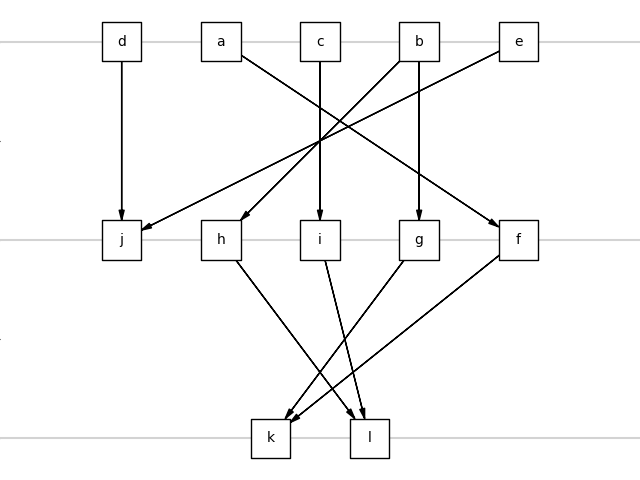

In [2]:
G = ogdf.Graph() # the graph
GA = ogdf.GraphAttributes(G, ogdf.GraphAttributes.all) # the drawing
LVL = ogdf.NodePartition(G) # the level-assignment with vertex orders

# load the graph
CG = ogdf.ClusterGraph(G)
CGA = ogdf.ClusterGraphAttributes(CG, ogdf.ClusterGraphAttributes.all)
ogdf.GraphIO.read(CGA, CG, G, "counterexample.gml")
GA.__assign__(CGA)
from_cluster(CG, LVL)

## This is an interactive editor for the input instance and its initial layout.
# draw&drop to change levels / orders
# dbl-click to create node
# click to select node/edge
# del to delete selected node/edge
# ctrl-click on lower node to create an edge from selected node
## After changing the graph, you can re-run the Algo in the cells below by selecting a cell and clicking the play button.
MatplotlibLevelGraphEditor(GA, LVL)

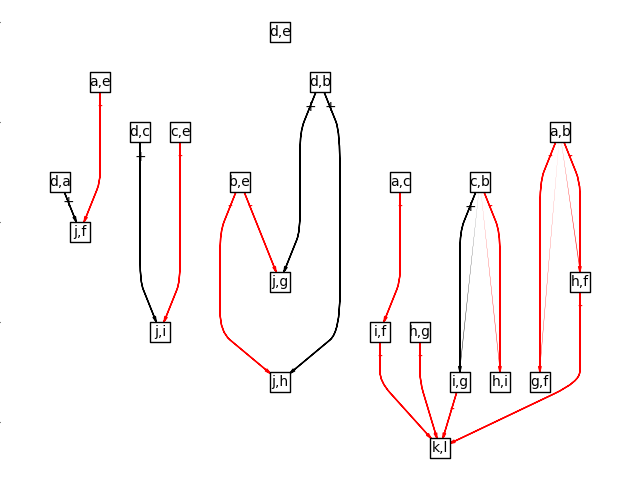

In [3]:
# compute the VE graph
VE = ogdf.Graph()
VEA = ogdf.GraphAttributes(VE, ogdf.GraphAttributes.all)

VEmap = {} # bijection between pairs of G-nodes and VE-nodes
VEl = defaultdict(list) # used for ordering VE-nodes according to Algo 2
VELVL = ogdf.NodePartition(VE) # leveling according to VEl
for i, nodes in enumerate(LVL.cells()):
    for a, b in combinations(nodes, 2):
        n = VE.newNode()
        VEA.label[n] = f"{GA.label[a]},{GA.label[b]}"
        VEmap[n] = (a, b)
        VEmap[(a, b)] = n
        VEmap[(b, a)] = n
        VEl[(i, -abs(LVL.positionOf(a) - LVL.positionOf(b)))].append(n)

# translate the temporary VEl lists to a leveling (aka NodePartition)
for i, (k, ns) in enumerate(sorted(VEl.items())):
    while i >= VELVL.size(): VELVL.newCell()
    for n in ns: VELVL.moveToCell(n, i)
del VEl

# label edges with '+' or '-' depending on whether corresponding edge pairs cross in G/GA/LVL
VEminus = ogdf.EdgeArray[bool](VE, False) # True if a VE-edge is labeled '-'
for i, nodes in enumerate(LVL.cells()):
    E = [adj.theEdge() for n in nodes for adj in n.adjEntries if adj.isSource()]
    for f, s in combinations(E, 2):
        if f.source() == s.source() or f.target() == s.target(): continue
        e = VE.newEdge(VEmap[(f.source(), s.source())], VEmap[(f.target(), s.target())])
        ord1 = LVL.positionOf(f.source()) < LVL.positionOf(s.source())
        ord2 = LVL.positionOf(f.target()) < LVL.positionOf(s.target())
        VEA.label[e] = "-" if ord1 != ord2 else "+"
        VEA.strokeColor[e] = RED if ord1 != ord2 else BLACK
        VEminus[e] = ord1 != ord2

cppinclude("ogdf/layered/SugiyamaLayout.h")
SL = ogdf.SugiyamaLayout()
SL.arrangeCCs(False)
SL.call(VEA, VELVL.cellAssignment())

## alternatively draw at regular positions according to levels
# drawLevelGraph(VEA, VELVL.cells(), scaleX=50, scaleY=100)

VEA

In [4]:
# compute/label the connected components
CC = ogdf.NodeArray[int](VE, -1)
CCnum = ogdf.connectedComponents(VE, CC)
seen = set()

# pi, visited and S as defined by Algorithm 1 (Lines 1-2)
pi = {}
visited = ogdf.NodeArray[bool](VE, False)
S = []

# Algo 1 Lines 3-7
for ns in VELVL.cells():
    for n in ns:
        if CC[n] in seen: continue
        seen.add(CC[n])

        # Lines 5-6
        # n is a VE-nodes so map it to the pair of G-nodes
        u, v = VEmap[n]
        if LVL.positionOf(u) < LVL.positionOf(v):
            pi[n] = u, v
        else:
            pi[n] = v, u
        #print((u, v), pi[n])

        # Line 7
        # Harrigan and Healy use `false` here, but this leads to their test already failing
        # while using `true` makes more sense and yields correct test results
        S.append((u, v, n, True))
assert(len(seen) == CCnum)

# Algo 1 Lines 8-23
while S:
    u, v, n, value = S.pop()
    visited[n] = True
    #print((u,v), VEA.label(n), value)
    for adj in n.adjEntries:
        tn = adj.twinNode()
        w, x = VEmap[tn]
        #print("\t", (w,x), VEA.label(tn), '+' if not VEminus[adj.theEdge()] else '-', VEA.label(adj.theEdge()))

        # Lines 12-23
        if not VEminus[adj.theEdge()]: # '+'
            p = w, x; q = x, w
            if not visited[tn]: S.append((w, x, tn, value))
        else: # '-'
            p = x, w; q = w, x
            if not visited[tn]: S.append((w, x, tn, not value))

        if (LVL.positionOf(w) < LVL.positionOf(x) and value) or (LVL.positionOf(x) < LVL.positionOf(w) and not value):
            if visited[tn] and pi[tn] != p: print("Non-Level-Planar!", pi[tn], "!=", p)
            pi[tn] = p
        else:
            if visited[tn] and pi[tn] != q: print("Non-Level-Planar!", pi[tn], "!=", q)
            pi[tn] = q

# color pairs that are swapped wrt their label gray
for n in VE.nodes:
    VEA.fillColor[n] = GRAY if pi[n] != VEmap[n] else WHITE

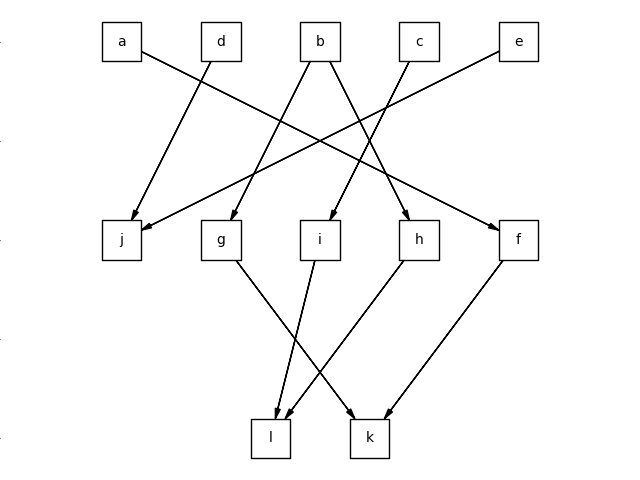

In [5]:
visited = {} # Algo 2 uses a different `visited`, now mapping to ordered pairs instead of bools
GAc = ogdf.GraphAttributes(GA) # copy of the drawing where we can exchange vertex positions

# function defined in the text of the paper
def match(n):
    C = CC[n]
    Cn = VEmap[visited[C]] # visited contains an order for the *first* visited node of the CC
    if pi[Cn] == visited[C] and LVL.positionOf(u) < LVL.positionOf(v) and pi[n] == (u, v): return True
    if pi[Cn] == visited[C] and LVL.positionOf(v) < LVL.positionOf(u) and pi[n] == (v, u): return True
    if pi[Cn] != visited[C] and LVL.positionOf(u) < LVL.positionOf(v) and pi[n] == (v, u): return True
    if pi[Cn] != visited[C] and LVL.positionOf(v) < LVL.positionOf(u) and pi[n] == (u, v): return True
    return False

# Algorithm 2
# we already ordered the nodes in VELVL appropriately
for i, ns in enumerate(VELVL.cells()):
    for j, n in enumerate(ns):
        # Lines 5-9
        plusCnt = minusCnt = 0
        for adj in n.adjEntries:
            tn = adj.twinNode()
            if VELVL.cellOf(tn) < i or (VELVL.cellOf(tn) == i and VELVL.positionOf(tn) < j):
                if not VEminus[adj.theEdge()]: # '+'
                    plusCnt += 1
                else: # '-'
                    minusCnt += 1

        # Lines 10-17
        u, v = VEmap[n]
        if CC[n] not in visited:
            if LVL.positionOf(u) < LVL.positionOf(v):
                visited[CC[n]] = u, v
            else:
                visited[CC[n]] = v, u
        elif plusCnt + minusCnt == 0 and not match(n):
            GAc.x[u], GAc.x[v] = GAc.x[v], GAc.x[u]
        if minusCnt > 1:
            GAc.x[u], GAc.x[v] = GAc.x[v], GAc.x[u]

GAc